## Motif Mapping

Using Ciera Martinez's map_motif.py in a generalized jupyter notebook function.

Author: Jemima Shi

In [210]:
import numpy as np
import pandas as pd
import re
import Bio

# For computations
import string
import random
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt

from Bio import SeqIO
from Bio import pairwise2
from IPython.display import Image
from Bio.pairwise2 import format_alignment
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline
plt.style.use('fivethirtyeight')

import os, sys
from Bio import motifs
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Alphabet import IUPAC, generic_dna, generic_protein

## Data Processing

Reads in the alligned raw DNA sequences and motifs to be pipelined:

1. Saves a copy of the sequence without the '$-$' included.

2. Casts the undashed version as IUPACUnambiguousDNA().

3. Calculates the thresholds to be used in assigning scores for likihood of the motif appearing.

4. Takes the indicies that have been scored and maps them to the corresponding raw sequence index, taking into consideration if the strand was positive or negative.

5. Returns a df with $\scriptsize{[\textbf{position}, \textbf{score, sequence length}, \textbf{species}, \textbf{raw_position index}, \textbf{strand positioning}, \textbf{aligned position}]}$.

$\textbf{*calculate_all_TFBS(files, all_motifs) will start the pipeline}$

The following reads in the files from the local directory and filters them according to the file types.

Both sequences and motifs are saved as lists. [files has 3540 fasta files & all_motifs has 91 motif files]

In [211]:
#Reads through and saves the names of all same files(.fa and .fm respectively) found in the same directory.

files = glob('../data/alignments/*0.fa')
all_motifs = glob('../data/pwm/*.fm')

In [212]:

def read_records(file):
    """
    file: a single .fa file within the directory.
    
    Returns the records from a .fa file as a list .
    """
    return list(SeqIO.parse(file, "fasta"))

In [213]:

def read_motif(motif):
    """
    motif: a single .fm file within the directory.
    
    Returns a motif.jaspar.Motif (the motif matrix) from the .fm file.
    """
    return motifs.read(open(motif), "pfm")

In [214]:
first_file = read_records(files[0])
first_motif = read_motif(all_motifs[2])

The following functions clean the read in alligned sequences, taking out the '-' in them and then casting them as needed. We then feed this cleaned format to create a pssm (PositionSpecificScoringMatrix) with a patser_threshold applied on it to output a score with a corresponding index. Depending on the sign of the position we labeled the DNA strand as positive or negative and then saved all the calculated values as columns in a pandas df.

In [215]:

def raw_sequence_ungap(records):
    """
    records: a list of species within a single .fa file.
    
    Returns a list of Sequences with an ungapped('-') sequence.
    """
    raw_sequences = []
    for record in records:
        raw_sequences.append(SeqRecord(record.seq.ungap("-"), id = record.id))
    return raw_sequences

In [216]:

def cast_sequence(ungapped_sequence):
    """
    ungapped_sequence: a list with the sequence and id for all the species in a file.
    
    Returns a list sequences with the type cast as c.
    """
    casted = []
    for record in ungapped_sequence:
        casted.append(Seq(str(record.seq), IUPAC.IUPACUnambiguousDNA()))
    return casted

In [217]:
first_raw_ungapped = raw_sequence_ungap(first_file)

In [218]:
first_cast = cast_sequence(first_raw_ungapped)

In [219]:
first_raw_ungapped[0]

SeqRecord(seq=Seq('AACTTTTTGGCACACCTTTGGAAAACATTTTTCGTACAGAAAAGTTACAAATTC...ACA', SingleLetterAlphabet()), id='VT0850|1|MEMB007D|+|2300', name='<unknown name>', description='<unknown description>', dbxrefs=[])

In [220]:
first_cast[0]

Seq('AACTTTTTGGCACACCTTTGGAAAACATTTTTCGTACAGAAAAGTTACAAATTC...ACA', IUPACUnambiguousDNA())

In [221]:

def calculate_pssm(chosen_motif, pseudocounts=0.0):
    """
    chosen_motif: Chosen motif sequence to be used in creating the pwm
    pseudocounts: Default set to 0.0, otherwise added to the counts before calculating position-weight matrix.
    
    Returns the pssm (PositionSpecificScoringMatrix)
    """
    pwm = chosen_motif.counts.normalize(pseudocounts)
    return pwm.log_odds()

In [222]:

def pwm_threshold(cast_sequences, chosen_motif):
    """
    cast_sequences: A list of sequences that have been ungapped and casted.
    chosen_motif: Chosen motif sequence to be used in creating the pwm
    
    Returns a list of pssm values
    """
    pssm = calculate_pssm(chosen_motif)
    pssm_list = [ ]
    for seq in cast_sequences:
        pssm_list.append(pssm.calculate(seq))
    return pssm_list

In [223]:

def extract_len_id(raw_seq, raw_seq2):
    """
    raw_seq: A list of raw sequences that hasn't yet been cast.
    raw_seq2: A list of cast & ungapped sequences.
    
    Returns a list of dictionary pairs for the species and seq_len of each sequence.
    """
    raw_id = []
    record_length = []
    for seq in raw_seq:
        try:
            raw_id.append(seq.id)
        except AttributeError:
            raw_id.append('n/a')
            
    for record in raw_seq2:
            record_length.append(len(record))
    return [{'species': x, 'seq_len': y} for x, y in zip(raw_id, record_length)]

Below are functions used to find the corresponding positions in the sequence and then mark them as negative or positive strands based on if the value was below or above 0 respectively. 

In [224]:

def positions(raw_sequence, cast_sequences, motif, chosen_precision=10**4):
    """
    raw_sequence: A list of the sequences that have been ungapped but not casted.
    cast_sequences: A list of sequences that have been ungapped and casted.
    motif: the chosen motif file read in using read_motif
    precision: default precision set to 10**4 to be used in the pssm distribution.
    
    Returns a list of positions
    """
    pssm = calculate_pssm(motif)
    distribution = pssm.distribution(background=motif.background, precision= chosen_precision)
    patser_threshold = distribution.threshold_patser()
    
    position_list = []
    len_and_ids = extract_len_id(raw_sequence, cast_sequences)
    for i in range(len(len_and_ids)):
        for position, score in pssm.search(cast_sequences[i], threshold= patser_threshold):
            positions = {'species': len_and_ids[i].get('species'), 'score':score, 
                         'position':position, 'seq_len': len_and_ids[i].get('seq_len') }
            position_list.append(positions)
    return position_list

In [225]:

def positive_positions(df):
    """
    df: The df with position, score, seq_len, and species.
    
    Returns a df where the position arguments are translated into positive ints.
    """
    temp_pos = df[df["position"] >= 0].copy()
    temp_neg = df[df["position"] < 0].copy()
    temp_pos["raw_position"] = temp_pos["position"]
    temp_neg["raw_position"] = temp_neg["seq_len"] + temp_neg["position"]  
    temp_together = temp_pos.append(temp_neg).reset_index().sort_values("index")

    return temp_together.set_index("index")

In [226]:

def define_sign(df):
    """
    df: The df with position, score, seq_len, species, and raw_position.
    
    Returns the df with a strand sign column appended on.
    """
    df["strand"] = np.where(df['position'] >= 0, 'positive', 'negative')
    return df

In [227]:

def merge_align_df(raw_df, aligned_seq, raw_id_len):
    """
    raw_df: A pandas df that contains the positions, score, seq_len, species, and strand orientation.
    aligned_seq: Original inputted sequence with the '-' still included.
    raw_id_len: The length of the o
    
    Returns a df with alignned index appended to raw_df sorted by ['species', 'raw_position'] 
    with N/A values dropped.
    
    """
    remap_list = []
    nuc_list = ['A', 'a', 'G', 'g', 'C', 'c', 'T', 't', 'N', 'n']

    for i in range(raw_id_len):
        counter = 0
        for xInd, x in enumerate(aligned_seq[i].seq):    
            if x in nuc_list:
                remaps = {'raw_position': counter, 'align_position':xInd, 'species':aligned_seq[i].id}
                counter += 1
                remap_list.append(remaps)
            
    remap_DF = pd.DataFrame(remap_list)
    TFBS_map_DF_all = pd.merge(raw_df, remap_DF, on=['species', 'raw_position'], how='outer')
    TFBS_map_DF_all = TFBS_map_DF_all.sort_values(by=['species','align_position'], ascending=[True, True])

    return TFBS_map_DF_all.dropna()   

In [228]:

def save_df(TFBS_df, align_file, motif_file):
    """
    TFBS_df: A pandas df with the raw/aligned position, score, and file names.
    align_file: Name of read in alignment file.
    motif_file: Name of read in motif file.
    
    Returns a csv copy of the df stored in the current directory
    """
    return TFBS_df.to_csv(motif_file + ".csv", sep='\t', na_rep="NA")

A generalized function that can be run on the files and motif lists to generate all possible permuations. This will return a df like this one for:

$\scriptsize\textbf{Fasta}$: 'align_outlier_rm_with_length_VT0809.fa'

$\scriptsize\textbf{Motif}$: 'bcd_cell2008.fm'


<img src="attachment:Screen%20Shot%202018-04-26%20at%2012.06.24%20AM.png" width="60%">

In [229]:

def calculate_dfs_TFBS(files, all_motifs):
    """
    files: A list of all the .fa files in the current directory.
    all_motifs: A list of all the .fm files in the current directory.
    
    Returns a df with the positions, score, and orientation saved into the current directory for all files.
    """
    for file in files:
        for motif in all_motifs:
            curr_file = read_records(file)
            curr_motif = read_motif(motif)
            curr_raw = raw_sequence_ungap(curr_file)
            curr_cast = cast_sequence(curr_raw)
            
            len_raw = len(extract_len_id(curr_raw, curr_cast))
            raw_df = pd.DataFrame(positions(curr_raw, curr_cast, curr_motif))
            temp_df = positive_positions(raw_df)
            temp_df = define_sign(temp_df)
            
            align_name = re.split(r'_', files[0])[-1]
            final_df = merge_align_df(temp_df, curr_file, len_raw)
            
            save_df(final_df, align_name, motif)
            return final_df

# Creating a Standard Score Distribution
The following 4 cells generate a random sequence, finds the 95 percentile cutoff point in the scores of the random sequence (differs depending on which motif you use), and uses this as the standard cutoff point for your own observed scores.

In [230]:

# Randomly generates a sequence
def generate_one_seq():
    header = "VT0000|1|MEMB001A|-|"+str(np.random.randint(1000,9000))
    random_list = [random.choice("ACGT-") for i in range(5000)]
    sequence = "".join(random_list) # 1 long string
    return header + "\n" + sequence

In [231]:
# Creates a fasta file with randomly generated sequences
ofile = open("../data/alignments/random_fasta.txt", "w")

for i in range(24):
    ofile.write(">" + generate_one_seq() + "\n")

ofile.close()

standard_file = glob('../data/alignments/*random_fasta.txt')[0]

In [232]:
def stand_cutoff(file, motifs, motif_to_use):
    """
    files: one fasta file (string)
    motifs: a list of motifs
    motif_to_use: a number to index into (chose 1 motif you want to use)
    Returns the 95th percentile of the scores, and the mean of the scores 
    """
    motif = motifs[motif_to_use]
    curr_file = read_records(file)
    curr_motif = read_motif(motif)
    curr_raw = raw_sequence_ungap(curr_file)
    curr_cast = cast_sequence(curr_raw)

    len_raw = len(extract_len_id(curr_raw, curr_cast))
    raw_df = pd.DataFrame(positions(curr_raw, curr_cast, curr_motif))
    temp_df = positive_positions(raw_df)
    percentile_95 = np.percentile(temp_df["score"], 95)
    standard_mean = temp_df["score"].mean()
    return (percentile_95, standard_mean)

#### The following cell prints out:
1. the standard 95 percentile "cutoff" point for the 2nd motif ('../data/pwm/cad_FlyReg.fm')
2. The 50th percentile (mean)

In [233]:
print(stand_cutoff(standard_file, all_motifs, 2))

(2.5869240760803223, 1.0431760862704709)


## Data Extraction

Taking the dfs that come from the "calculate_all_TFBS" function we filter out those with a score above the 95th percentile. With the filtered out values we match the species with their respective DNA sequences and then locate and save the given motif within the DNA sequence. Whether the strand is positive or negative is treated individually and the -'s are included in the sequence indexing. This newly extracted information is saved as columns and appended to the df.

<img src="attachment:Screen%20Shot%202018-04-26%20at%2012.23.58%20AM.png" width="60%">!

The following 3 cells provide a convenient way to access the standard "cutoff" point when using the 4 motifs printed below. cutoff_dict is used in the filter_95_percentile function.

In [234]:
all_motifs

['../data/pwm/bcd_FlyReg.fm',
 '../data/pwm/cad_FlyReg.fm',
 '../data/pwm/eve_new6.fm',
 '../data/pwm/zelda_.fm']

In [235]:
cutoff_dict = {}
cutoff_dict["Motif 1"] = stand_cutoff(standard_file, all_motifs, 0)[0]
cutoff_dict["Motif 2"] = stand_cutoff(standard_file, all_motifs, 1)[0]
cutoff_dict["Motif 3"] = stand_cutoff(standard_file, all_motifs, 2)[0]
cutoff_dict["Motif 4"] = stand_cutoff(standard_file, all_motifs, 3)[0]

In [236]:
cutoff_dict

{'Motif 1': 3.3171534538269043,
 'Motif 2': 2.6483244895935059,
 'Motif 3': 2.5869240760803223,
 'Motif 4': 6.6781315803527832}

In [237]:
def filter_95_percentile(TFBS_df, motif_used):
    """
    motif_used: a string that specifies the motif you used (e.g. "Motif 2")
    TFBS_df: A pandas df with the raw/aligned position, score, and file names.
    
    returns the TFBS_df with only values above the 95th percentile.
    """
    minimum = cutoff_dict[motif_used]
    filtered_df = TFBS_df[TFBS_df["score"] >= minimum]
    print("Filtered to scores above", minimum, "based on", motif_used)
    return filtered_df

#### From here on, we're going to apply these functions to the files we imported in, using Motif 2.

In [238]:
# *** Debugged version of calculate_dfs_TFB

def calculate_one_dfs_TFBS(file, all_motifs):
    """
    file: A single .fa file from the current directory.
    all_motifs: A list of all the .fm files in the current directory.
    
    Returns a df with the positions, score, and orientation saved into the current directory for all files.
    """

    for motif in all_motifs:
        curr_file = read_records(file)
        curr_motif = read_motif(motif)
        curr_raw = raw_sequence_ungap(curr_file)
        curr_cast = cast_sequence(curr_raw)

        len_raw = len(extract_len_id(curr_raw, curr_cast))
        raw_df = pd.DataFrame(positions(curr_raw, curr_cast, curr_motif))
        temp_df = positive_positions(raw_df)
        temp_df = define_sign(temp_df)

        align_name = re.split(r'_', files[0])[-1]
        final_df = merge_align_df(temp_df, curr_file, len_raw)

    return final_df

In [239]:
# EXAMPLE
TBFS_df = calculate_one_dfs_TFBS(files[0], all_motifs)
TBFS_df.head()

,position,score,seq_len,species,raw_position,strand,align_position
465,23.0,2.304673,2035.0,VT0850|1|MEMB002A|-|2035,23.0,positive,25
466,-1918.0,2.304673,2035.0,VT0850|1|MEMB002A|-|2035,117.0,negative,139
467,125.0,2.304673,2035.0,VT0850|1|MEMB002A|-|2035,125.0,positive,154
468,-1879.0,2.304673,2035.0,VT0850|1|MEMB002A|-|2035,156.0,negative,191
469,-1856.0,2.304673,2035.0,VT0850|1|MEMB002A|-|2035,179.0,negative,230


In [240]:
# LOOP THROUGH & APPLY TO ALL THE ALIGNMENTS
tables = []
for i in files[:50]:
    tables.append(calculate_one_dfs_TFBS(i, [all_motifs[1]]))

In [241]:
# EXAMPLE
# Only show the rows with scores above the 95% threshold.
# Also removes a few unnecessary columns
filtered = filter_95_percentile(TBFS_df, "Motif 2")
filtered = filtered.drop(['seq_len', 'position'], axis=1)
filtered.head()

Filtered to scores above 2.64832448959 based on Motif 2


,score,species,raw_position,strand,align_position
472,6.678132,VT0850|1|MEMB002A|-|2035,255.0,positive,325
475,6.678132,VT0850|1|MEMB002A|-|2035,328.0,positive,441
476,6.678132,VT0850|1|MEMB002A|-|2035,332.0,negative,445
477,6.678132,VT0850|1|MEMB002A|-|2035,336.0,negative,482
480,6.678132,VT0850|1|MEMB002A|-|2035,399.0,positive,584


In [242]:
# LOOP THROUGH & APPLY TO ALL THE ALIGNMENTS
filtered_tables = []
for i in tables:
    f = filter_95_percentile(i, "Motif 2").drop(['seq_len', 'position'], axis=1)
    filtered_tables.append(f)

Filtered to scores above 2.64832448959 based on Motif 2
Filtered to scores above 2.64832448959 based on Motif 2
Filtered to scores above 2.64832448959 based on Motif 2
Filtered to scores above 2.64832448959 based on Motif 2
Filtered to scores above 2.64832448959 based on Motif 2
Filtered to scores above 2.64832448959 based on Motif 2
Filtered to scores above 2.64832448959 based on Motif 2
Filtered to scores above 2.64832448959 based on Motif 2
Filtered to scores above 2.64832448959 based on Motif 2
Filtered to scores above 2.64832448959 based on Motif 2
Filtered to scores above 2.64832448959 based on Motif 2
Filtered to scores above 2.64832448959 based on Motif 2
Filtered to scores above 2.64832448959 based on Motif 2
Filtered to scores above 2.64832448959 based on Motif 2
Filtered to scores above 2.64832448959 based on Motif 2
Filtered to scores above 2.64832448959 based on Motif 2
Filtered to scores above 2.64832448959 based on Motif 2
Filtered to scores above 2.64832448959 based on 

In [243]:
def map_raw_seq(TFBS_df, seq_file):
    """
    TFBS_df: The TFBS_df with entries only above the 95th percentile.
    seq_file: a single .fa file within the directory.
    
    returns a df with scores in the upper 5th percentile along with the species'
    corresponding raw sequence.
    """
    
    values = [[record.seq, record.description] for record in seq_file]
    sequences = pd.DataFrame(values)
    sequences.rename(columns={0 : 'Sequence', 1: 'Description'}, inplace=True)
    sequences = sequences.set_index("Description")
    mapping = sequences.to_dict("index")
    
    upper_fifth = filter_95_percentile(TFBS_df, "Motif 2")
    upper_fifth = upper_fifth[["species", "raw_position",'align_position', "strand"]]
    upper_fifth["sequence"] = upper_fifth["species"].apply(lambda x: str(mapping.get(x).get("Sequence")))
    
    upper_fifth = upper_fifth.reset_index().drop("index", axis=1)
    
    return upper_fifth

In [244]:
def positive_index_seq(matched_df, motif):
    """
    matched_df: df with the species matched with their corresponding raw sequence.
    motif: a single .fm file within the directory.
    
    returns the df with appended columns of the DNA sequences/indices starting from the 
    raw_index from positively oriented scores and then going on until the proper number
    of letters have been found.
    """
    motif = str(first_motif.consensus)
    motif_len = len(motif)
    
    extracted_seqs = []
    extracted_indices = []
    
    pos = matched_df[matched_df["strand"] == "positive"]
    final = pos.copy()
    for i in np.arange(pos.shape[0]):
        curr_row = pos.iloc[i]
        curr_seq = curr_row["sequence"]
        index = int(curr_row["raw_position"])
        
        selected_seq = curr_seq[index:index + motif_len]     
        letters = re.findall(r'[^-]', selected_seq)
        additional_indicies = 0
        
        if len(letters) != motif_len: 
            while len(re.findall(r'[^-]', selected_seq)) != motif_len:
                additional_indicies += 1
                selected_seq = curr_seq[index:index + motif_len + additional_indicies]
                 
        selected_index = "{0}:{1}".format(index, index + motif_len + additional_indicies)
        extracted_seqs.append(selected_seq)
        extracted_indices.append(selected_index)
        
    final["extracted_seq"] = extracted_seqs
    final["extracted_indices"] = extracted_indices
    return final

In [245]:
def negative_index_seq(matched_df, motif):
    """
    matched_df: df with the species matched with their corresponding raw sequence.
    motif: a single .fm file within the directory.
    
    returns the df with appended columns of the DNA sequences/indices starting from the 
    raw_index from negatively oriented scores and then going on until the proper number
    of letters have been found.
    """
    motif = str(first_motif.consensus)
    motif_len = len(motif)
    
    extracted_seqs = []
    extracted_indices = []
    
    d={'A':'T','T':'A', 'C':'G', 'G':'C'}
    
    neg = matched_df[matched_df["strand"] == "negative"]
    final = neg.copy()
    for i in np.arange(neg.shape[0]):
        curr_row = neg.iloc[i]
        curr_seq = curr_row["sequence"]
        
        index = int(curr_row["raw_position"])
        
        selected_seq = curr_seq[-(index + motif_len + 1): -(index + 1)]     
        letters = re.findall(r'[^-]', selected_seq)
        additional_indicies = 0
        
        if len(letters) != motif_len: 
            while len(re.findall(r'[^-]', selected_seq)) != motif_len:
                additional_indicies += 1
                selected_seq = curr_seq[-(index + motif_len + additional_indicies + 1): -(index + 1)]
                 
        selected_index = "{0}:{1}".format(-(index + motif_len + additional_indicies + 1), -(index + 1)) 
        
        swapped_seq = ''.join(d[s] if s in d else s for s in selected_seq)
        reversed_seq = swapped_seq[::-1]
        extracted_seqs.append(reversed_seq)
        extracted_indices.append(selected_index)
        
    final["extracted_seq"] = extracted_seqs
    final["extracted_indices"] = extracted_indices
    return final

In [246]:
def find_motif_pipeline(TFBS_df, seq_file, motif):
    """
    TFBS_df: A pandas df with the raw/aligned position, score, and file names.
    seq_file: a single .fa file within the directory.
    motif: a single .fm file within the directory.
    
    returns the execution of the pipeline for filtering out the calculated motif locations
    and the actual DNA sequence.
    """
    matched = map_raw_seq(TFBS_df, seq_file)
    final_p = positive_index_seq(matched, motif)
    final_n = negative_index_seq(matched, motif)
    final = final_p.reset_index().merge(final_n.reset_index(), how='outer').sort_values('index').set_index('index')
    final["gap_less_seq"] = [re.sub(r'-', '', x) for x in final["extracted_seq"]]
    return final[["species", "raw_position", "strand","gap_less_seq", "extracted_indices", 'align_position']]


A pipeline for reading in the list of fasta files and motifs and then generating all possible combinations between the two lists to create the specific motif's sequence logo and the corresponding stripplot for locations of the motif against all the species. Currently saves the images into the current directory. 

Example output for $\scriptsize\textbf{Fasta}$: 'align_outlier_rm_with_length_VT0809.fa'
$\scriptsize\textbf{Motif}$: 'bcd_cell2008.fm'

<img src="attachment:Screen%20Shot%202018-04-26%20at%209.23.37%20AM.png" width="80%">


#### *final_df is the scored table of everything 
#### *indexed_df has the upper 95th percentile / extracted motifs and their locations

In [247]:

def calculate_one_TFBS(file, motif):
    """
    file: A single .fa file in the current directory.
    motif: A single .fm file in the current directory.
    
    Returns a csv with the positions, score, and orientation saved into the current directory for the specified 
    .fa and .fm files.
    """
    curr_file = read_records(file)
    curr_motif = read_motif(motif)
    curr_raw = raw_sequence_ungap(curr_file)
    curr_cast = cast_sequence(curr_raw)
            
    len_raw = len(extract_len_id(curr_raw, curr_cast))    
    raw_df = pd.DataFrame(positions(curr_raw, curr_cast, curr_motif))
    temp_df = positive_positions(raw_df)
    temp_df = define_sign(temp_df)
            
    align_name = re.split(r'_', files[0])[-1]
    final_df = merge_align_df(temp_df, curr_file, len_raw)
    save_df(final_df, align_name, motif)
    
    new_path = curr_motif.weblogo("{}.png".format(motif), format= 'PNG', stack_width= 'large')
    display(Image("{}.png".format(motif), width= 200, height= 300))

    indexed_df = find_motif_pipeline(final_df, curr_file, curr_motif)
    testing_pos = indexed_df[indexed_df["strand"] == 'positive']
    testing_neg = indexed_df[indexed_df['strand'] == 'negative']

    fig = plt.figure(figsize=(20, 15))
    plt.subplot(2, 1, 1)
    sns.stripplot(x="align_position", y="species", hue="strand", data=testing_pos, dodge=True, linewidth=1)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,title='Orientation', fontsize='x-large')
    plt.xlabel('')
    plt.title('{} & {} Alignment'.format(align_name, motif))

    plt.subplot(2, 1, 2)
    sns.stripplot(x="align_position", y="species", hue="strand", data=testing_neg,
                  palette="Set2", dodge=True, linewidth=1)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,title='Orientation', fontsize='x-large')
    plt.xlabel('')
    
    #fig.savefig('{} & {}.png'.format(align_name, motif), dpi=fig.dpi, bbox_inches='tight', pad_inches=0.5)
    return final_df


In [248]:
#calculate_one_TFBS(files[0],all_motifs[0])

In [249]:

def calculate_all_TFBS(files, all_motifs):
    """
    files: A list of all the .fa files in the current directory.
    all_motifs: A list of all the .fm files in the current directory.
    
    Returns a csv with the positions, score, and orientation saved into the current directory for all files.
    """
    for file in files:
        for motif in all_motifs:
            calculate_one_TFBS(file, motif)
            

In [250]:
#calculate_all_TFBS(files[:1], all_motifs[:2])

In [251]:
#Run this cell to generate the plots for all the files with all the possible motif files.
#Will save the scored df, motif sequence logo, and file/motif stripplot into the current directory.

#calculate_all_TFBS(files, all_motifs)

#### June 21 Task - Begin reading from here

### Filtered_tables
* filtered_tables is a LIST of TABLES; each table in this list represents ONE alignment file. In every table, 1 row represents a spot on the sequence that we've chosen to label as TFBS, based on our 95% criteria. You can index into filtered_tables to view any one table. For example, alignment 1:

In [252]:
filtered_tables[0].head()

,score,species,raw_position,strand,align_position
10649,2.648324,VT0850|1|MEMB002A|-|2035,10.0,positive,12
10684,2.648324,VT0850|1|MEMB002A|-|2035,47.0,positive,56
10707,2.648324,VT0850|1|MEMB002A|-|2035,71.0,positive,92
10710,2.648324,VT0850|1|MEMB002A|-|2035,75.0,positive,96
10740,2.700792,VT0850|1|MEMB002A|-|2035,106.0,negative,128


### position_species_tables
(See below for example) position_species_tables is also a LIST of TABLES. Again, each element in the list represents ONE alignment file. Each table tells you:

1. The raw position
2. A tuple containing all the species that have TBFS's at that position

In [253]:
position_species_tables = []

for f in filtered_tables:
    positions_with_TFBS = list(f["raw_position"]) # there are ~2,000 positions
    combos = {} # Dictionary with position index : list of species that have TFBS at this position
    for i in positions_with_TFBS:
        combos[i] = list(f[f["raw_position"] == i]["species"])

    d = {'Raw Positions': list(combos.keys()),
         'Species with TFBS at Position': list(combos.values())}
    positions_species = pd.DataFrame(data=d)
    positions_species["Species with TFBS at Position"] = [tuple(i) for i in positions_species["Species with TFBS at Position"]]

    position_species_tables.append(positions_species)

In [254]:
position_species_tables[0].head(3)

,Raw Positions,Species with TFBS at Position
0,10.0,"(VT0850|1|MEMB002A|-|2035, VT0850|1|MEMB002B|-..."
1,12.0,"(VT0850|1|MEMB002D|+|2189, VT0850|1|MEMB002F|+..."
2,30.0,"(VT0850|1|MEMB002E|+|2250, VT0850|1|MEMB003A|-..."


### group_by_combo_tables
Another LIST of tables. Similar to position_species_tables, except each table provides:

1. Index: the ID of each unique combination (starts from 0, 1, 2.....)
2. Species with TFBS at Position: a tuple containing a list of species, in other words, 1 combination.
3. Count: The frequency at which each combination occurs

In [255]:
group_by_combo_tables = []

for p in position_species_tables:
    group_by_combo = p.groupby("Species with TFBS at Position",sort=False).count().reset_index()
    group_by_combo.columns = ["Species with TFBS at Position", "Count"]
    group_by_combo_tables.append(group_by_combo)


In [256]:
group_by_combo_tables[0].head(3)

,Species with TFBS at Position,Count
0,"(VT0850|1|MEMB002A|-|2035, VT0850|1|MEMB002B|-...",1
1,"(VT0850|1|MEMB002D|+|2189, VT0850|1|MEMB002F|+...",2
2,"(VT0850|1|MEMB002E|+|2250, VT0850|1|MEMB003A|-...",1


### counts_at_positions_tables
Another LIST of tables. Each table is the merging of the respective tables from position_species and group_by_combo. This one summarizes all the information we've obtained so far.

In [257]:
counts_at_positions_tables = []
num_alignments = len(group_by_combo_tables)

for n in range(num_alignments):
    counts_at_positions = position_species_tables[n].merge(group_by_combo_tables[n], how="left",sort=False)
    counts_at_positions.set_index("Raw Positions", inplace=True)
    counts_at_positions_tables.append(counts_at_positions)

In [258]:
counts_at_positions_tables[0].head(3)

,Species with TFBS at Position,Count
Raw Positions,,
10.0,"(VT0850|1|MEMB002A|-|2035, VT0850|1|MEMB002B|-...",1
12.0,"(VT0850|1|MEMB002D|+|2189, VT0850|1|MEMB002F|+...",2
30.0,"(VT0850|1|MEMB002E|+|2250, VT0850|1|MEMB003A|-...",1


In [259]:
position_to_count_dictionaries = []

for c in counts_at_positions_tables:
    positions = list(c.index.values)
    dictionary = {}
    for i in range(len(positions)):
        if i in positions:
            dictionary[i] = c["Count"][i]
        else:
            dictionary[i] = 0
    position_to_count_dictionaries.append(dictionary)

In [260]:
def freq_at_position(raw_position, alignment):
    """
    raw_position: intege
    alignment: integer
    
    Returns the frequency of the pattern occurring at the specified raw position.
    Must specify which alignment file is being used.
    """
    return position_to_count_dictionaries[alignment][raw_position]

In [261]:
# Example: this is the frequency of the pattern occuring at position 12 in the first alignment.
freq_at_position(12, 0)

2

## Visualizations

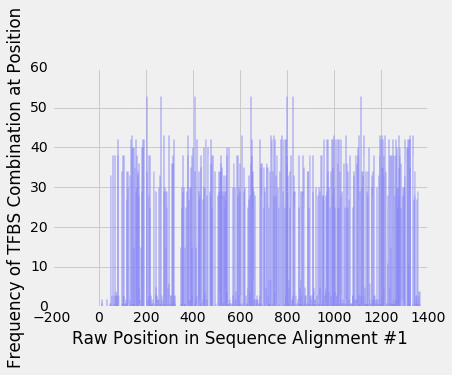

In [262]:
pos = list(position_to_count_dictionaries[0].keys())
y_pos = np.arange(len(pos))
freqs = list(position_to_count_dictionaries[0].values())
 
plt.bar(y_pos, freqs, align='center', alpha=0.5, width = 3)
plt.xlabel("Raw Position in Sequence Alignment #1")
plt.ylabel("Frequency of TFBS Combination at Position")

### ID Dictionary
Use the function ID_dictionary (defined below) when you have an ID and want to view the pattern associated with that ID.

In [263]:
# For convenience, here are dictionaries of IDs that map to a combination.

all_combo_ids = []

for g in group_by_combo_tables:
    combo_ids = {}
    for i in g.index.values:
        combo = g["Species with TFBS at Position"][i]
        combo_ids[i] = combo
    all_combo_ids.append(combo_ids)

In [264]:
def ID_dictionary(alignment, ID):
    """
    alignment: integer specifying which alignment to analyze
    ID: integer; ID linked to the unique TFBS combination
    """
    return all_combo_ids[alignment][ID]

In [265]:
# Example: from alignment 2, ID #11 represents this combination of species.
ID_dictionary(2, 11)

('VT10600|0|MEMB002E|-|729',
 'VT10600|0|MEMB003A|+|713',
 'VT10600|0|MEMB003B|+|702',
 'VT10600|0|MEMB003D|-|714',
 'VT10600|0|MEMB004B|-|689',
 'VT10600|0|MEMB004E|-|727',
 'VT10600|0|MEMB005B|+|719',
 'VT10600|0|MEMB005D|-|733',
 'VT10600|0|MEMB006A|-|740',
 'VT10600|0|MEMB006B|+|689',
 'VT10600|0|MEMB006C|+|713',
 'VT10600|0|MEMB007C|+|679',
 'VT10600|0|MEMB008C|+|711',
 'VT10600|0|dkik|+|726')

# TLDR:
#### These functions incorporate everything done above.
1. Use **frequent_patterns** function to find the top few occurring TFBS patterns in your specified alignment file.
2. Use **most_frequent_pattern** function to find the top occuring TFBS pattern in your specified alignment file.

In [266]:
def frequent_patterns(alignment_num, percentile=80):
    """
    alignment_num: integer specifying which alignment to analyze
    percentile: (integer) limit frequencies to only above this percentile
    
    Returns:
    A table, like those in group_by_combo_tables, except w/only the largest counts
    """
    counts = list(counts_at_positions_tables[alignment_num]["Count"])
    table = group_by_combo_tables[alignment_num]
    return table[table["Count"] >= np.percentile(counts, percentile)]

frequent_patterns(0)

,Species with TFBS at Position,Count
9,"(VT0850|1|MEMB005B|-|2353,)",38
11,"(VT0850|1|MEMB006C|+|2323,)",43
12,"(VT0850|1|MEMB002F|+|2216,)",38
27,"(VT0850|1|MEMB007D|+|2300,)",42
30,"(VT0850|1|MEMB006A|+|2240,)",40
34,"(VT0850|1|MEMB003B|+|2201,)",38
44,"(VT0850|1|MEMB008C|+|2426,)",42
53,"(VT0850|1|dkik|-|2904,)",53


In [267]:
def most_frequent_pattern(alignment_num):
    """
    alignment_num: integer specifying which alignment to analyze
    
    Returns:
    A single-row table with the TFBS combo with the LARGEST count in the sequence
    """
    max_count = max(list(counts_at_positions_tables[alignment_num]["Count"]))
    table = group_by_combo_tables[alignment_num]
    return table[table["Count"] == max_count]

most_frequent_pattern(1) # <- In the second alignment, the most frequent combo occurs 52 times.

,Species with TFBS at Position,Count
66,"(VT0870|0|MEMB007B|+|2647,)",52
